In [1]:
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
import pandas as pd,os
import torch
from statistics import mode
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer
from datasets import Dataset, load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pickle
from transformers import RobertaConfig, RobertaModel
import torch
from torch import nn
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback,AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat.textstat import textstatistics
import pandas as pd
import language_tool_python
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

c:\Users\Ghiki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()

    
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, extra_data), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [37]:
df = pd.read_json('datasets/subtaskB_dev.jsonl', lines=True)

print(f'Original dataset')
print(df.info())

print(f'''\n{df['label'].value_counts()}''')
print(f'''\n{df['model'].value_counts()}''')
print(f'''\n{df['source'].value_counts()}''')

df = df[['text', 'label']]
test_df=df

test_texts = test_df['text'].tolist()

Original dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   model   3000 non-null   object
 2   source  3000 non-null   object
 3   label   3000 non-null   int64 
 4   id      3000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 117.3+ KB
None

label
1    500
0    500
3    500
2    500
4    500
5    500
Name: count, dtype: int64

model
chatGPT    500
human      500
davinci    500
cohere     500
bloomz     500
dolly      500
Name: count, dtype: int64

source
peerread    3000
Name: count, dtype: int64


In [3]:
MODEL1 = 'bert-base-uncased'
MODEL2 = 'roberta-base'
MODEL3 = 'distilbert-base-uncased'
MODEL4 = 'google/electra-base-discriminator'
MODEL5 = 'albert-base-v2'
MODEL6 = 'multimodal-roberta-base'
MODEL7 = 'multimodal-extended-roberta-base'

MODEL_PATH1='SavedModels/optimized-bert-base-uncased-50k'
MODEL_PATH2='SavedModels/optimized-roberta-base-30k'
MODEL_PATH3='SavedModels/optimized-distilbert-base-uncased-50k'
MODEL_PATH4='SavedModels/optimized-electra-base-discriminator-50k'
MODEL_PATH5='SavedModels/optimized-albert-base-v2-15k'
MODEL_PATH6='SavedModels/optimized-roberta-base-multimodal-70k'
MODEL_PATH7='SavedModels/optimized-roberta-base-multimodal-extended-70k'

'''Preparing data'''

df = pd.read_json('datasets/subtaskB_dev.jsonl', lines=True)

print(f'Original dataset')
print(df.info())

print(f'''\n{df['label'].value_counts()}''')
print(f'''\n{df['model'].value_counts()}''')
print(f'''\n{df['source'].value_counts()}''')

df = df[['text', 'label']]
test_df=df

test_texts = test_df['text'].tolist()

from scipy.special import expit

def getPrediction(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
    label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
        )

    test_dataset = Dataset.from_pandas(test_df)

    def preprocess_function(examples, **fn_kwargs):
        return fn_kwargs['tokenizer'](examples["text"], truncation=True)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(tokenized_test_dataset)
    probs = expit(predictions.predictions)  # Use sigmoid instead of softmax
    preds = np.argmax(predictions.predictions, axis=-1)

    return preds, probs

def getPredictionMultidomain(model_path,num_extra_dims,test_data):
    config = RobertaConfig.from_pretrained(model_path)
    model = CustomSequenceClassification(config, num_extra_dims)
    model.load_state_dict(torch.load(model_path+'/pytorch_model.bin'))
    trainer = Trainer(model=model)
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(test_data)
    probs = expit(predictions.predictions)  # Use sigmoid instead of softmax
    preds = np.argmax(predictions.predictions, axis=-1)

    return preds, probs

print(f'\nProcessing with {MODEL1}')
labels1,scores1=getPrediction(MODEL_PATH1)

print(f'\nProcessing with {MODEL2}')
labels2,scores2=getPrediction(MODEL_PATH2)

print(f'\nProcessing with {MODEL3}')
labels3,scores3=getPrediction(MODEL_PATH3)

print(f'\nProcessing with {MODEL4}')
labels4,scores4=getPrediction(MODEL_PATH4)

print(f'\nProcessing with {MODEL5}')
labels5,scores5=getPrediction(MODEL_PATH5)

df_multidomain_extended=pd.read_csv('datasets/features_df_test_extended.csv')

reduced_columns=['word_count','avg_sentence_length','avg_word_length','gunning_fog_index','grammatical_errors','text','label']
df_multidomain=df_multidomain_extended[reduced_columns]

df_multidomain_extraData=df_multidomain.drop(['label'],axis=1)
df_multidomain_extraData=df_multidomain_extraData.drop(['text'],axis=1)

df_multidomain_extended_extraData=df_multidomain_extended.drop(['label'],axis=1)
df_multidomain_extended_extraData=df_multidomain_extended_extraData.drop(['text'],axis=1)

ds_test_extended = Dataset.from_dict({
        "text": df_multidomain_extended['text'].tolist(), 
        "extra_data": df_multidomain_extended_extraData.values.tolist(),
        "labels": df_multidomain_extended['label'].tolist()
    })

ds_test = Dataset.from_dict({
        "text": df_multidomain['text'].tolist(), 
        "extra_data": df_multidomain_extraData.values.tolist(),
        "labels": df_multidomain['label'].tolist()
    })

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenized_ds_test_extended = ds_test_extended.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
tokenized_ds_test_extended = tokenized_ds_test_extended.map(lambda x: {'extra_data': x['extra_data']})

tokenized_ds_test = ds_test.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
tokenized_ds_test = tokenized_ds_test.map(lambda x: {'extra_data': x['extra_data']})

print(f'\nProcessing with {MODEL6}')
labels6,scores6=getPredictionMultidomain(MODEL_PATH6,5,tokenized_ds_test)

print(f'\nProcessing with {MODEL7}')
labels7,scores7=getPredictionMultidomain(MODEL_PATH7,9,tokenized_ds_test_extended)

scores1 = [scores1[i][labels1[i]] for i in range(len(labels1))]
scores2 = [scores2[i][labels2[i]] for i in range(len(labels2))]
scores3 = [scores3[i][labels3[i]] for i in range(len(labels3))]
scores4 = [scores4[i][labels4[i]] for i in range(len(labels4))]
scores5 = [scores5[i][labels5[i]] for i in range(len(labels5))]
scores6 = [scores6[i][labels6[i]] for i in range(len(labels6))]
scores7 = [scores7[i][labels7[i]] for i in range(len(labels7))]

Original dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   model   3000 non-null   object
 2   source  3000 non-null   object
 3   label   3000 non-null   int64 
 4   id      3000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 117.3+ KB
None

label
1    500
0    500
3    500
2    500
4    500
5    500
Name: count, dtype: int64

model
chatGPT    500
human      500
davinci    500
cohere     500
bloomz     500
dolly      500
Name: count, dtype: int64

source
peerread    3000
Name: count, dtype: int64

Processing with bert-base-uncased


Map: 100%|██████████| 3000/3000 [00:00<00:00, 5017.26 examples/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 34.60it/s]



Processing with roberta-base


Map: 100%|██████████| 3000/3000 [00:00<00:00, 8257.45 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 34.43it/s]



Processing with distilbert-base-uncased


Map: 100%|██████████| 3000/3000 [00:00<00:00, 7810.77 examples/s]
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:05<00:00, 64.71it/s] 



Processing with google/electra-base-discriminator


Map: 100%|██████████| 3000/3000 [00:00<00:00, 6141.48 examples/s]
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 34.50it/s]



Processing with albert-base-v2


Map: 100%|██████████| 3000/3000 [00:00<00:00, 5480.99 examples/s]
You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Map: 100%|██████████| 3000/3000 [00:00<00:00, 29677.59 examples/s]



Processing with multimodal-roberta-base


100%|██████████| 375/375 [00:15<00:00, 24.91it/s]



Processing with multimodal-extended-roberta-base


100%|██████████| 375/375 [00:15<00:00, 24.98it/s]


In [17]:
MODEL8 = 'onevsall-roberta-base'
MODEL_PATH8_0='SavedModels/roberta-base_label0_0k'
MODEL_PATH8_1='SavedModels/roberta-base_label1_0k'
MODEL_PATH8_2='SavedModels/roberta-base_label2_0k'
MODEL_PATH8_3='SavedModels/roberta-base_label3_0k'
MODEL_PATH8_4='SavedModels/roberta-base_label4_0k'
MODEL_PATH8_5='SavedModels/roberta-base_label5_0k'

def getPredictionBinary(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    id2label = {0: "not_current_model", 1: "current_model"}
    label2id = {"not_current_model": 0, "current_model": 1}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
        )

    test_dataset = Dataset.from_pandas(test_df)

    def preprocess_function(examples, **fn_kwargs):
        return fn_kwargs['tokenizer'](examples["text"], truncation=True)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(tokenized_test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    probs = softmax(predictions.predictions, axis=-1)
    label_specific_probs = probs[:, 1]  # This extracts the probability for label 1
    
    return list(preds),list(label_specific_probs)

print(f'\nProcessing with {MODEL8} label 0')
labels8_0,scores8_0=getPredictionBinary(MODEL_PATH8_0)

print(f'\nProcessing with {MODEL8} label 1')
labels8_1,scores8_1=getPredictionBinary(MODEL_PATH8_1)

print(f'\nProcessing with {MODEL8} label 2')
labels8_2,scores8_2=getPredictionBinary(MODEL_PATH8_2)

print(f'\nProcessing with {MODEL8} label 3')
labels8_3,scores8_3=getPredictionBinary(MODEL_PATH8_3)

print(f'\nProcessing with {MODEL8} label 4')
labels8_4,scores8_4=getPredictionBinary(MODEL_PATH8_4)

print(f'\nProcessing with {MODEL8} label 5')
labels8_5,scores8_5=getPredictionBinary(MODEL_PATH8_5)


Processing with onevsall-roberta-base label 0


Map: 100%|██████████| 3000/3000 [00:00<00:00, 6894.42 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 34.60it/s]



Processing with onevsall-roberta-base label 1


Map: 100%|██████████| 3000/3000 [00:00<00:00, 7847.28 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 35.10it/s]



Processing with onevsall-roberta-base label 2


Map: 100%|██████████| 3000/3000 [00:00<00:00, 8445.09 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 35.00it/s]



Processing with onevsall-roberta-base label 3


Map: 100%|██████████| 3000/3000 [00:00<00:00, 4297.81 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 34.18it/s]



Processing with onevsall-roberta-base label 4


Map: 100%|██████████| 3000/3000 [00:00<00:00, 8171.53 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:11<00:00, 33.83it/s]



Processing with onevsall-roberta-base label 5


Map: 100%|██████████| 3000/3000 [00:00<00:00, 8222.16 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 375/375 [00:10<00:00, 34.22it/s]


In [29]:
df_onevsall = pd.DataFrame({
    f'Labels_0': labels8_0,
    f'Scores_0': scores8_0,
    f'Labels_1': labels8_1,
    f'Scores_1': scores8_1,
    f'Labels_2': labels8_2,
    f'Scores_2': scores8_2,
    f'Labels_3': labels8_3,
    f'Scores_3': scores8_3,
    f'Labels_4': labels8_4,
    f'Scores_4': scores8_4,
    f'Labels_5': labels8_5,
    f'Scores_5': scores8_5,
})

def process_labels_and_scores(df):
    labels8 = []
    scores8 = []

    for _, row in df.iterrows():
        labels = [row[f'Labels_{i}'] for i in range(6)]
        scores = [row[f'Scores_{i}'] for i in range(6)]

        if labels.count(1) == 1:
            # Only one label is 1
            label_index = labels.index(1)
            selected_label = label_index
            selected_score = scores[label_index]
        elif labels.count(1) > 1:
            # Multiple labels are 1, choose the one with the highest score
            selected_label = scores.index(max(scores))
            selected_score = max(scores)
        else:
            # All labels are 0, choose the one with the lowest score and invert the score
            selected_label = scores.index(min(scores))
            selected_score = 1 - min(scores)

        labels8.append(selected_label)
        scores8.append(selected_score)

    return labels8, scores8

labels8, scores8 = process_labels_and_scores(df_onevsall)

In [38]:
def getMetrics(predicted_labels, true_labels):
    # Ensure the labels are numpy arrays
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro', zero_division=0)

    # Create a dictionary of metrics
    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

    return metrics

print(MODEL1)
print(getMetrics(labels1,test_df['label'].tolist()))
print('')
print(MODEL2)
print(getMetrics(labels2,test_df['label'].tolist()))
print('')
print(MODEL3)
print(getMetrics(labels3,test_df['label'].tolist()))
print('')
print(MODEL4)
print(getMetrics(labels4,test_df['label'].tolist()))
print('')
print(MODEL5)
print(getMetrics(labels5,test_df['label'].tolist()))
print('')
print(MODEL6)
print(getMetrics(labels6,test_df['label'].tolist()))
print('')
print(MODEL7)
print(getMetrics(labels7,test_df['label'].tolist()))
print('')
print(MODEL8)
print(getMetrics(labels8,test_df['label'].tolist()))

bert-base-uncased
{'accuracy': 0.6583333333333333, 'f1': 0.6185394311264053, 'precision': 0.6192174884481815, 'recall': 0.6583333333333333}

roberta-base
{'accuracy': 0.7473333333333333, 'f1': 0.7167924853853949, 'precision': 0.7252336532426344, 'recall': 0.7473333333333333}

distilbert-base-uncased
{'accuracy': 0.654, 'f1': 0.6295894012802586, 'precision': 0.6580674916276797, 'recall': 0.6539999999999999}

google/electra-base-discriminator
{'accuracy': 0.684, 'f1': 0.6546814757852748, 'precision': 0.6841279878821579, 'recall': 0.684}

albert-base-v2
{'accuracy': 0.674, 'f1': 0.654733141514451, 'precision': 0.6594659303977864, 'recall': 0.6739999999999999}

multimodal-roberta-base
{'accuracy': 0.759, 'f1': 0.7186877887437483, 'precision': 0.7309157154173311, 'recall': 0.759}

multimodal-extended-roberta-base
{'accuracy': 0.742, 'f1': 0.7095807039739542, 'precision': 0.7254381710357943, 'recall': 0.742}

onevsall-roberta-base
{'accuracy': 0.732, 'f1': 0.6996097578573203, 'precision': 0.

In [39]:
from sklearn.linear_model import LogisticRegression

models = [MODEL1, MODEL2, MODEL3, MODEL4, MODEL5, MODEL6, MODEL7, MODEL8]

df = pd.DataFrame({
    f'Labels_{MODEL1}': labels1,
    f'Scores_{MODEL1}': scores1,
    f'Labels_{MODEL2}': labels2,
    f'Scores_{MODEL2}': scores2,
    f'Labels_{MODEL3}': labels3,
    f'Scores_{MODEL3}': scores3,
    f'Labels_{MODEL4}': labels4,
    f'Scores_{MODEL4}': scores4,
    f'Labels_{MODEL5}': labels5,
    f'Scores_{MODEL5}': scores5,
    f'Labels_{MODEL6}': labels6,
    f'Scores_{MODEL6}': scores6,
    f'Labels_{MODEL7}': labels7,
    f'Scores_{MODEL7}': scores7,
    f'Labels_{MODEL8}': labels8,
    f'Scores_{MODEL8}': scores8,
})

labels = test_df['label'].tolist()

df.info()

def ensemble_methods(df, models):
    def majority_voting(df, models):
        """ Majority Voting Ensemble """
        votes = df[[f'Labels_{m}' for m in models]].mode(axis=1)
        return votes[0]

    def averaging_ensemble(df, models, threshold=0.5):
        """ Averaging Ensemble with threshold for class labels """
        avg_scores = df[[f'Scores_{m}' for m in models]].mean(axis=1)
        return (avg_scores >= threshold).astype(int)
    
    def majority_voting_with_tie_breaking(df, models):
        """ Enhanced Majority Voting with Tie-Breaking by Score Mean """
        votes = df[[f'Labels_{m}' for m in models]].mode(axis=1)
        final_labels = []

        for row in range(len(df)):
            if len(votes.columns) == 1:
                final_labels.append(votes.iloc[row, 0])  # No tie
            else:
                # In case of a tie, break it by mean score
                tied_labels = votes.iloc[row]
                tied_scores = {}
                for label in tied_labels:
                    if pd.notna(label):
                        tied_scores[label] = df.loc[row, [f'Scores_{m}' for m in models if df.loc[row, f'Labels_{m}'] == label]].mean()
                if tied_scores:
                    final_labels.append(max(tied_scores, key=tied_scores.get))
                else:
                    final_labels.append(np.nan)  # Handle case with all NaNs

        return final_labels

    def mean_score_voting(df, models):
        """ Mean Score Voting with Tie-Breaking based on Vote Count """
        # Create a DataFrame to hold the mean scores for each label
        mean_scores_df = pd.DataFrame()

        # Calculate mean scores for each label
        for label in set(df[[f'Labels_{m}' for m in models]].values.flatten()):
            if pd.notna(label):
                mean_scores_df[label] = df[[f'Scores_{m}' for m in models if df[f'Labels_{m}'].iloc[0] == label]].mean(axis=1)

        # Determine the label with the highest mean score for each row
        max_mean_scores = mean_scores_df.idxmax(axis=1)

        final_labels = []
        for i, label in enumerate(max_mean_scores):
            # Check for ties in mean scores
            tied_labels = mean_scores_df.columns[mean_scores_df.iloc[i] == mean_scores_df.iloc[i][label]]
            if len(tied_labels) > 1:
                # If there's a tie, choose the label with the most votes
                vote_counts = df[[f'Labels_{m}' for m in models]].apply(lambda x: (x == tied_labels).sum(), axis=1).iloc[i]
                final_labels.append(vote_counts.idxmax())
            else:
                final_labels.append(label)

        return final_labels
    
    def rank_voting(df, models, top_n=3):
        """ Rank Voting """
        final_labels = []
        for row in range(len(df)):
            points = {label: 0 for label in set(df.iloc[row, [df.columns.get_loc(f'Labels_{m}') for m in models]].values) if pd.notna(label)}
            for m in models:
                label = df.at[row, f'Labels_{m}']
                score = df.at[row, f'Scores_{m}']
                # Assign points based on score, higher score gets more points
                if pd.notna(label):
                    points[label] += score
            # Sort the labels based on points and take the top label
            sorted_labels = sorted(points, key=points.get, reverse=True)
            final_labels.append(sorted_labels[0] if sorted_labels else np.nan)
        return final_labels
    
    def borda_count_voting(df, models):
        """ Borda Count Voting """
        final_labels = []

        for row in range(len(df)):
            points = {label: 0 for label in set(df[[f'Labels_{m}' for m in models]].iloc[row].values) if pd.notna(label)}

            # Collect scores and labels for the current row across all models
            scores_labels = [(df.at[row, f'Scores_{m}'], df.at[row, f'Labels_{m}']) for m in models]

            # Sort the scores_labels based on scores
            scores_labels.sort(reverse=True)

            # Assign Borda points based on ranking
            for i, (_, label) in enumerate(scores_labels):
                if pd.notna(label):
                    points[label] += len(models) - i

            # Choose the label with maximum points, handle the case with no valid labels
            final_labels.append(max(points, key=points.get) if points else np.nan)

        return final_labels

    
    return {
        'Majority Voting':majority_voting(df, models),
        # 'Average Voting':averaging_ensemble(df, models),
        'Majority Score Tie Break Voting': majority_voting_with_tie_breaking(df, models),
        # 'Mean Score Voting': mean_score_voting(df, models),
        'Rank Voting': rank_voting(df, models),
        'Borda Count Voting': borda_count_voting(df, models),
    }
    
    
ensemble_results = ensemble_methods(df, models)

for voting_method, details in ensemble_results.items():
    print(f'''{voting_method}: {getMetrics(details,labels)['accuracy']}''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Labels_bert-base-uncased                  3000 non-null   int64  
 1   Scores_bert-base-uncased                  3000 non-null   float32
 2   Labels_roberta-base                       3000 non-null   int64  
 3   Scores_roberta-base                       3000 non-null   float32
 4   Labels_distilbert-base-uncased            3000 non-null   int64  
 5   Scores_distilbert-base-uncased            3000 non-null   float32
 6   Labels_google/electra-base-discriminator  3000 non-null   int64  
 7   Scores_google/electra-base-discriminator  3000 non-null   float32
 8   Labels_albert-base-v2                     3000 non-null   int64  
 9   Scores_albert-base-v2                     3000 non-null   float32
 10  Labels_multimodal-roberta-base      

In [40]:
import itertools

# Assuming all_models is a list of your model names
all_models = [MODEL1, MODEL2, MODEL3, MODEL4, MODEL5, MODEL6, MODEL7, MODEL8]

# This will store the best F1 score, the corresponding model combination, and the voting method
best_f1_score = 0
best_model_combination = None
best_voting_method = None
best_metrics=None

# Define the voting methods you want to evaluate
voting_methods = ['Majority Voting','Majority Score Tie Break Voting','Rank Voting','Borda Count Voting']

# Try all possible combinations of the models
for r in tqdm(range(1, len(all_models) + 1), desc='Model Combinations'):
    for model_combination in itertools.combinations(all_models, r):
        # Generate the predictions using the ensemble of the current combination of models
        ensemble_results = ensemble_methods(df, model_combination)
        
        # Evaluate each voting method
        for method in voting_methods:
            metrics=getMetrics(ensemble_results[method], labels)
            f1_score=metrics['accuracy']
            
            # Update the best combination if the current one is better
            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_model_combination = model_combination
                best_voting_method = method
                best_metrics=metrics

# Print the best combination, its score, and the voting method
print(f"Best Accuracy Score: {best_f1_score}")
print(f"Best Model Combination: {best_model_combination}")
print(f"Best Voting Method: {best_voting_method}")
print(f"Best Metrics: {best_metrics}")

Model Combinations: 100%|██████████| 8/8 [07:47<00:00, 58.40s/it]

Best Accuracy Score: 0.768
Best Model Combination: ('roberta-base', 'multimodal-roberta-base')
Best Voting Method: Majority Voting
Best Metrics: {'accuracy': 0.768, 'f1': 0.7266056974216345, 'precision': 0.7286733771545394, 'recall': 0.7679999999999999}


In [41]:
models = [MODEL2, MODEL6]

df_reduced = pd.DataFrame({
    f'Labels_{MODEL2}': labels2,
    f'Scores_{MODEL2}': scores2,
    f'Labels_{MODEL6}': labels6,
    f'Scores_{MODEL6}': scores6,
})

ensemble_results = ensemble_methods(df, models)

for voting_method, details in ensemble_results.items():
    print(f'''{voting_method}: {getMetrics(details,labels)['accuracy']}''')

Majority Voting: 0.768
Majority Score Tie Break Voting: 0.7613333333333333
Rank Voting: 0.7613333333333333
Borda Count Voting: 0.7613333333333333


In [10]:
result_labels=ensemble_results['Majority Voting']
df = pd.read_json('datasets/subtaskB_dev.jsonl', lines=True)
df['id']

0        1844
1        1845
2        1846
3        1847
4        1848
        ...  
2995    14560
2996    14561
2997    14562
2998    14563
2999    14564
Name: id, Length: 3000, dtype: int64

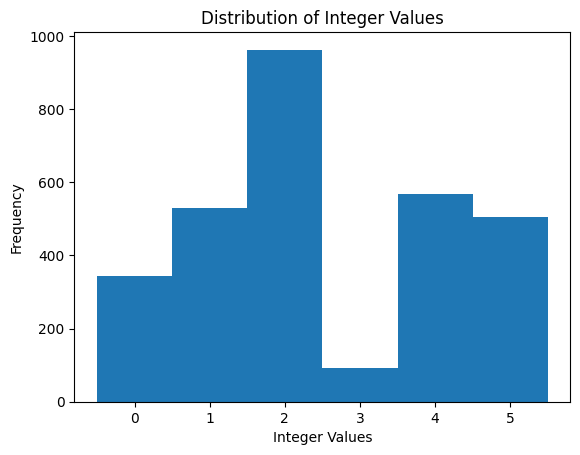

In [12]:
import matplotlib.pyplot as plt
result_labels = [int(num) for num in result_labels]

# Display the distribution of integer values
plt.hist(result_labels, bins=range(min(result_labels), max(result_labels) + 2), align='left')
plt.xlabel('Integer Values')
plt.ylabel('Frequency')
plt.title('Distribution of Integer Values')
plt.show()

In [15]:
new_df = pd.DataFrame({
    'id': df['id'],
    'label': result_labels
})

# Exporting to a jsonl file
new_df.to_json('datasets/subtask_b.json', orient='records', lines=True)